In [1]:
%config InlineBackend.figure_format = 'svg'

import itertools
%load_ext line_profiler

import scqubits as qubit
import scqubits.utils.plotting as plot
import scqubits.utils.sweep_plotting as splot
from scqubits.utils.spectrum_utils import extract_phase, order_eigensystem
from scqubits import HilbertSpace, InteractionTerm, ParameterSweep
from scqubits.core.storage import SpectrumData

import numpy as np
%matplotlib inline
import scipy as sp
import scipy.constants as const
from scipy import sparse
from scipy.special import hermite
import matplotlib.pyplot as plt
from matplotlib import cm

import scqubits.core.constants as constants
from scqubits.utils.spectrum_utils import get_matrixelement_table, matrix_element
from scqubits.core.discretization import GridSpec, Grid1d
from scqubits.core.qubit_base import QubitBaseClass
from scqubits.core.storage import WaveFunctionOnGrid
from scqubits.utils.fix_heiberger import fixheiberger

In [2]:
hGHz = const.h * 10**9
EJ = 1.0
ECJ = EJ / 60.
ALPHA = 0.8
FLUX=0.5
ECg = 50.0*ECJ
EJlist = np.array([EJ, EJ, ALPHA*EJ])
nglist = np.array([0.1, 0.0])
num_exc = 2
kmax=1

FQV = qubit.FluxQubitVCHOS(
    EJ1 = EJ, 
    EJ2 = EJ, 
    EJ3 = ALPHA*EJ, 
    ECJ1 = ECJ, 
    ECJ2 = ECJ, 
    ECJ3 = ECJ/ALPHA, 
    ECg1 = ECg, 
    ECg2 = ECg, 
    ng1 = nglist[0], 
    ng2 = nglist[1], 
    flux = FLUX,
    kmax=kmax, num_exc=num_exc, truncated_dim=6)
#FQVS = qubit.FluxQubitVCHOS(ECJ=ECJ, ECg=ECg, EJlist=EJlist, alpha=ALPHA, nglist=nglist, 
#                             flux=FLUX, kmax=kmax, num_exc=num_exc, squeezing=True, truncated_dim=6)
#FQVSG = qubit.FluxQubitVCHOSGlobal(ECJ=ECJ, ECg=ECg, EJlist=EJlist, alpha=ALPHA, nglist=nglist, 
#                             flux=FLUX, kmax=kmax, global_exc=num_exc, squeezing=True, truncated_dim=6)
FQVG = qubit.FluxQubitVCHOSGlobal(
    EJ1 = EJ, 
    EJ2 = EJ, 
    EJ3 = ALPHA*EJ, 
    ECJ1 = ECJ, 
    ECJ2 = ECJ, 
    ECJ3 = ECJ/ALPHA, 
    ECg1 = ECg, 
    ECg2 = ECg, 
    ng1 = nglist[0], 
    ng2 = nglist[1], 
    flux = FLUX,
    kmax=kmax, global_exc=num_exc, truncated_dim=6)
#FQVB = qubit.FluxQubitVCHOSTestingBabusci(ECJ=ECJ, ECg=ECg, EJ=EJ, alpha=ALPHA, ng1=0.0, ng2=0.0, 
#                                         flux=FLUX, kmax=1, num_exc=1, truncated_dim=6)

FQ = qubit.FluxQubit(
    EJ1 = EJ, 
    EJ2 = EJ, 
    EJ3 = ALPHA*EJ, 
    ECJ1 = ECJ, 
    ECJ2 = ECJ, 
    ECJ3 = ECJ/ALPHA, 
    ECg1 = ECg, 
    ECg2 = ECg, 
    ng1 = nglist[0], 
    ng2 = nglist[1], 
    flux = FLUX, 
    ncut = 15,)

In [4]:
FQ.eigenvals()

array([1.61825437, 1.6219451 , 1.77671354, 1.82972859, 1.88439505,
       1.88498153])

In [3]:
def get_hilbertdim(global_exc, param_vals):
    FQVG.global_exc = global_exc
    maxhilbertdim = 0
    for param in param_vals:
        FQVG.flux = param
        hilbertdim = FQVG.hilbertdim()
        if hilbertdim > maxhilbertdim:
            maxhilbertdim = hilbertdim
    return maxhilbertdim

In [4]:
def get_nnz(global_exc, param_vals, cutoff):
    FQVG.global_exc = global_exc
    maxnnz = 0
    for param in param_vals:
        FQVG.flux = param
        ham = FQVG.hamiltonian()
        ham[np.abs(ham) < cutoff] = 0.0
        nnz = np.count_nonzero(ham)
        print(nnz)
        if nnz > maxnnz:
            maxnnz = nnz
    return maxnnz

In [5]:
flux_list = np.linspace(0.46, 0.54, 21)
FQ.ncut = 15
specdata_ed = FQ.get_spectrum_vs_paramvals('flux', flux_list, evals_count=4, subtract_ground=False)
rel_dev_v = []
hilbert_dim_v = []
nnz_v = []
for ncut in range(1, 11):
    FQVG.global_exc = ncut
    specdata_v_tmp = FQVG.get_spectrum_vs_paramvals('flux', flux_list, evals_count=4, subtract_ground=False)
    rel_dev_mat = np.abs(specdata_v_tmp.energy_table-specdata_ed.energy_table)/specdata_ed.energy_table
    max_rel_dev = np.max(rel_dev_mat)
    rel_dev_v.append(max_rel_dev)
    hilbertdim = get_hilbertdim(ncut, flux_list)
    hilbert_dim_v.append(hilbertdim)
    nnz_v.append(hilbertdim**2)
    specdata_prev = specdata_v_tmp
    print(ncut, hilbertdim, max_rel_dev)

1 6 0.030178511818401837


2 12 0.018033659045119155


3 20 0.011359031871751812


4 30 0.0027419772815089763


5 42 0.00041233330170306197


6 56 0.00018429418454801285


7 72 6.448371570968073e-05


8 90 1.969661008112447e-05


9 110 5.856379494203142e-06


10 132 1.0150600573356934e-06


In [6]:
rel_dev_ed = []
hilbert_dim_ed = []
nnz_ed = []
for ncut in range(1, 8):
    FQ.ncut = ncut
    specdata_ed_tmp = FQ.get_spectrum_vs_paramvals('flux', flux_list, evals_count=4, subtract_ground=False)
    nnz = np.count_nonzero(FQ.hamiltonian())
    hilbertdim = FQ.hilbertdim()
    rel_dev_mat = np.abs(specdata_ed_tmp.energy_table-specdata_ed.energy_table)/specdata_ed.energy_table
    max_rel_dev = np.max(rel_dev_mat)
    rel_dev_ed.append(max_rel_dev)
#    hilbert_dim_ed.append(FQ.hilbertdim())
    hilbert_dim_ed.append(hilbertdim)
    nnz_ed.append(nnz)
#    print(ncut, FQ.hilbertdim(), max_rel_dev)
    print(ncut, hilbertdim, max_rel_dev)

1 9 0.3444108090793304


2 25 0.09715566031824309


3 49 0.02396976516551592


4 81 0.004412043959105932


5 121 0.0004853472879120831


6 169 3.3204383311811974e-05


7 225 1.5436371186115359e-06


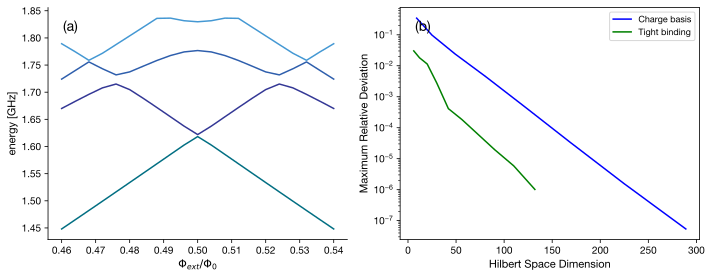

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
FQ.plot_evals_vs_paramvals('flux', flux_list, evals_count=4, subtract_ground=False, fig_ax = [fig, ax1])
ax2.plot(hilbert_dim_ed, rel_dev_ed, color="blue", label="Charge basis")
ax2.plot(hilbert_dim_v, rel_dev_v, color="green", label="Tight binding")
#ax2.plot(hilbert_dim_v_s, rel_dev_v_s, color="purple", label="Tight binding (Squeezing)")
ax1.annotate('(a)', xy=(0.05,0.9), xycoords='axes fraction', fontsize=14)
ax2.annotate('(b)', xy=(0.05,0.9), xycoords='axes fraction', fontsize=14)
legend = ax2.legend(fontsize=9)
plt.xlabel('Hilbert Space Dimension')
plt.ylabel('Maximum Relative Deviation')
plt.yscale('log')
#plt.xscale('log')
plt.tight_layout()
#plt.savefig('compare_tb_ed_FQ_EJEC_60_flux_squeeze.pdf')
plt.show()

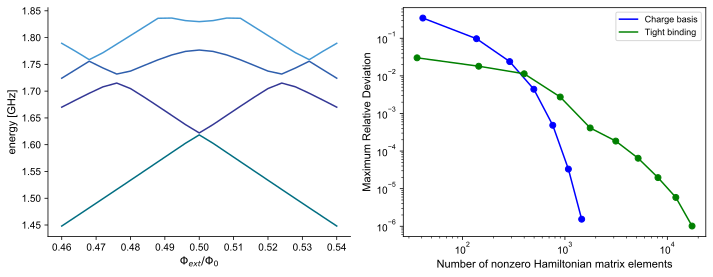

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
FQ.plot_evals_vs_paramvals('flux', flux_list, evals_count=4, subtract_ground=False, fig_ax = [fig, ax1])
ax2.plot(nnz_ed, rel_dev_ed, color="blue", label="Charge basis")
ax2.plot(nnz_ed, rel_dev_ed, 'bo')
ax2.plot(nnz_v, rel_dev_v, color="green", label="Tight binding")
ax2.plot(nnz_v, rel_dev_v, 'go')
#ax2.plot(hilbert_dim_v_s, rel_dev_v_s, color="purple", label="Tight binding (Squeezing)")
#ax1.annotate('(a)', xy=(0.05,0.9), xycoords='axes fraction', fontsize=14)
#ax2.annotate('(b)', xy=(0.05,0.9), xycoords='axes fraction', fontsize=14)
legend = ax2.legend(fontsize=9)
plt.xlabel('Number of nonzero Hamiltonian matrix elements')
plt.ylabel('Maximum Relative Deviation')
plt.xscale('log')
plt.yscale('log')
#plt.xscale('log')
plt.tight_layout()
plt.savefig('compare_tb_ed_FQ_EJEC_60_flux.pdf')
plt.show()

In [3]:
evals, evecs = FQV.eigensys()

In [4]:
evals

array([1.62083783, 1.62266347, 1.80701277, 1.83178196, 1.89303323,
       1.89348251])

In [5]:
evecs[:,0]

array([ 7.03906039e-01+1.42529221e-06j,  1.65704857e-06-1.01222156e-05j,
        1.23867466e-02+1.61900126e-05j, -4.12282051e-02+3.10491890e-05j,
        3.58074163e-06-1.16689570e-05j,  2.84559675e-02+2.12443707e-05j,
        2.70460803e-02-9.49862524e-06j,  4.52636422e-06-1.23164273e-05j,
        3.30272875e-03+2.71156560e-05j,  6.92912357e-01+1.23934064e-01j,
        1.73163895e-06-9.97304493e-06j,  1.21960585e-02+2.16496148e-03j,
        4.05769947e-02+7.28921382e-03j,  1.67576789e-06+1.21538422e-05j,
       -2.80152940e-02-4.98928303e-03j,  2.66220793e-02+4.77132091e-03j,
       -2.24705173e-06-1.29136541e-05j,  3.25602319e-03+5.54832259e-04j])

In [6]:
evals_test, evecs_test = FQV._singular_inner_product_helper(FQV.hamiltonian(), FQV.inner_product(), 6, False)

In [7]:
evals_test

array([1.62083783, 1.62266347, 1.80701277, 1.83178196, 1.89303323,
       1.89348251])

In [8]:
evecs_test[:, 0]

array([-7.03487907e-01+4.11117437e-02j, -1.06918760e-06+1.02121122e-05j,
       -1.23803700e-02+7.06641089e-04j,  4.12019602e-02-2.43775276e-03j,
       -2.90924423e-06+1.18674059e-05j, -2.84397924e-02+1.64884278e-03j,
       -2.70294197e-02+1.58992107e-03j, -3.83736398e-06+1.25676155e-05j,
       -3.30380103e-03+1.36621877e-04j, -6.99739335e-01-8.33891942e-02j,
       -1.14373135e-06+1.00676457e-05j, -1.23153384e-02-1.45068459e-03j,
       -4.09787721e-02-4.91358964e-03j, -2.39702770e-06-1.20457609e-05j,
        2.82890679e-02+3.35801369e-03j, -2.68848610e-02-3.21429781e-03j,
        3.03332982e-06+1.27707820e-05j, -3.28969840e-03-3.35285088e-04j])

In [18]:
M = FQVG.inner_product()
in_eigs, in_vec = sp.linalg.eigh(M)
print(in_eigs[0:10])
A = FQVG.hamiltonian()

AA, BB, alpha, beta, Q, Z = sp.linalg.ordqz(A, M, sort='rhp')
evals = alpha/beta
def filtercomplex(a):
    if np.abs(np.imag(a))>1e-8:
        return False
    else:
        return True
evals = np.real(list(filter(filtercomplex, evals)))
print(FQ.eigenvals())
print(evals)
print(alpha/beta)
#print(A[0:4, 0:4])
#gamma = np.random.rand(1)
#sigma = np.sqrt(1.0-gamma**2)
#sigma = np.random.rand(1)*1
#gamma = np.random.rand(1)*10
#sigma = 0.999
#gamma = np.sqrt(1.0-sigma**2)
#print(gamma, sigma)
#Abar_1 = +gamma*A + sigma*M
#Abar_2 = -gamma*A + sigma*M
#Abar_3 = -gamma*A - sigma*M
#Abar_4 = +gamma*A - sigma*M

#Mbar_1 = -sigma*A + gamma*M
#Mbar_2 = -sigma*A - gamma*M
#Mbar_3 = +sigma*A - gamma*M
#Mbar_4 = +sigma*A + gamma*M
#sigma = 100.0
#Mbar_4 = A + 10*M
#in_eigs_1, in_vec = sp.linalg.eigh(Mbar_1)
#in_eigs_2, in_vec = sp.linalg.eigh(Mbar_2)
#in_eigs_3, in_vec = sp.linalg.eigh(Mbar_3)
#in_eigs_4, in_vec = sp.linalg.eigh(Mbar_4)
#print(in_eigs_4[0:10])
#print(in_eigs_1[0:10])
#print(in_eigs_2[0:10])
#print(in_eigs_3[0:10])
#print(in_eigs_4[0:10])
#eigval_si, eigvec_si = sp.sparse.linalg.eigsh(np.real(A), M=M, sigma=0.01, return_eigenvectors=True, mode='buckling')
#print(eigval_si)
#eigval_1, eigvec = sp.linalg.eigh(Abar_1, b=Mbar_1, eigvals=(0, 5))
#eigval_2, eigvec = sp.linalg.eigh(Abar_2, b=Mbar_2, eigvals=(0, 5))
#eigval_3, eigvec = sp.linalg.eigh(Abar_3, b=Mbar_3, eigvals=(0, 5))
#eigval_4, eigvec = sp.linalg.eigh(Abar_4, b=Mbar_4, eigvals=(0, 5))
#AA, BB, Q, Z = sp.linalg.qz(A, M)
#AA, BB, alpha, beta, Q, Z = sp.linalg.ordqz(A, M, sort='rhp')
#print(alpha, beta, alpha/beta)
#eigval, _ = sp.linalg.eigh(A, b=M, eigvals=(0, 5))
#eigvals = np.array([AA[i, i]/BB[i, i] for i in range(AA.shape[0])])
#print(eigvals)
#print(eigval_4)
#eigval_prime = np.array([(eigval_4[i]*gamma+sigma)/(gamma-sigma*eigval_4[i])
#                        for i in range(len(eigval_4))])
#print(eigval_prime)

[-1.49921064e-13  4.16511930e-13  1.81055250e-11  1.89934267e-11
  3.30914613e-10  6.18621542e-10  1.73004372e-09  3.31948176e-09
  7.52405010e-09  1.88039142e-08]
[2.0863098  2.2510558  2.68895965 2.89871987 3.12523281 3.36806906]
[ 2.08630981  2.25105581  2.68895969  2.89871994  3.12523284  3.3680692
  3.57483809  3.73564271  3.94580631  4.17529419  4.38553445  4.41532679
 14.36478044  4.88262833  5.05840012  5.07469445  5.1076864   5.1942959
  5.22776227  5.78977357  5.92772147  6.06706845  6.14103286  6.3084111
  6.29453402  6.59596366  7.20794455  7.20856268  7.32958329  7.32411567
  8.77720228  8.77490003  9.3463564   9.69997473  7.70669311]
[18.67439683-2.10008932e-05j 17.98917265+1.80076516e-05j
  0.69058194-4.54914463e-04j  2.08630981+2.41054633e-14j
  2.25105581-1.89119297e-15j 16.60975646-8.01777154e-05j
 16.52965684-1.29560972e-04j  2.68895969+1.31941859e-13j
  2.89871994-1.26062375e-11j  3.12523284-6.70720198e-15j
 16.11319255-4.83213130e-06j 15.99762199+1.52105338e-06j
  

In [3]:
evals_ED = FQ.eigenvals()
print(evals_ED)

[2.05316567 2.34113    2.67070858 2.77132405 3.15502321 3.33232167]


In [4]:
evals = FQVG.eigenvals()
print(evals)

[2.05316568 2.34113    2.67070861 2.77132412 2.88433279 3.15502329]


/Users/danielweiss/PycharmProjects/scqubits/scqubits/core/vchos.py:666: UserWarning: Singular inner product. Attempt QZ algorithm
  warnings.warn("Singular inner product. Attempt QZ algorithm")


In [5]:
evals = FQVG.eigenvals()
print(evals)

[2.08630981 2.25105581 2.68895969 2.89871994 3.12523284 3.3680692 ]


/Users/danielweiss/PycharmProjects/scqubits/scqubits/core/vchos.py:666: UserWarning: Singular inner product. Attempt QZ algorithm
  warnings.warn("Singular inner product. Attempt QZ algorithm")


In [3]:
innprod = FQVG.inner_product()
ham = FQVG.hamiltonian()
print(innprod.shape[0])

90


In [4]:
evals, evecs = sp.linalg.eigh(innprod)
evals_h, evecs_h = sp.linalg.eigh(ham)
print(evals)
print(evals_h)

[-1.49921064e-13  4.16511930e-13  1.81055250e-11  1.89934267e-11
  3.30914613e-10  6.18621542e-10  1.73004372e-09  3.31948176e-09
  7.52405010e-09  1.88039142e-08  2.83986490e-08  6.72559480e-08
  1.40881436e-07  6.54921612e-07  7.99020058e-07  2.33936355e-06
  2.88271055e-06  3.05713786e-06  1.03310923e-05  1.59909917e-05
  2.94303938e-05  4.56503812e-05  1.29812277e-04  1.37437912e-04
  2.05315795e-04  2.13242027e-04  6.61947458e-04  7.31899427e-04
  1.23578593e-03  1.73370533e-03  2.41355010e-03  3.18579551e-03
  9.85120176e-03  1.36085124e-02  1.44505081e-02  2.03844350e-02
  2.43774049e-02  3.29737999e-02  6.94742046e-02  7.99990301e-02
  8.76401093e-02  1.09481900e-01  1.51750725e-01  1.71792529e-01
  1.86791869e-01  2.92699714e-01  3.27009970e-01  3.32951812e-01
  3.92391845e-01  4.39885885e-01  6.96996845e-01  7.65235817e-01
  7.80768941e-01  9.65475505e-01  1.09667857e+00  1.21895927e+00
  1.23921796e+00  1.31714792e+00  1.42958727e+00  1.53735943e+00
  1.56707618e+00  1.66831

In [17]:
evals = FQVG.eigenvals()
print(evals)

[2.0023746  2.39037768 2.66568022 2.75636854 3.1643064  3.33445548]


In [25]:
A = fixheiberger(ham, innprod, 1e-12)
print(A.shape[0])

88


In [26]:
evals_fh, evecs_fh = sp.linalg.eigh(A)
print(evals_fh)

[-18.39387788   2.08630981   2.25105581   2.68895969   2.8987202
   3.12523284   3.3680695    3.57483825   3.7356429    3.94580631
   4.17529495   4.38553476   4.41532794   4.88262845   5.05840013
   5.07469531   5.10768699   5.19429957   5.2277645    5.78977387
   5.92772491   6.06711878   6.14104431   6.29455401   6.30843779
   6.59596839   6.65504155   7.20794458   7.20857664   7.32412957
   7.32960395   7.70669696   7.70676511   7.81891418   7.82635992
   8.13479818   8.13532294   8.57193614   8.5742286    8.77490171
   8.77721731   9.34637786   9.34694652   9.50252386   9.50587953
   9.70036444   9.70133664  10.24315271  10.24445642  10.42923629
  10.42953029  10.92590638  10.93464487  11.21043547  11.21206658
  11.23502046  11.23562634  11.66418105  11.66639359  11.8706053
  11.88077916  12.15479564  12.15705936  12.70959911  12.73957035
  12.77091214  12.78424182  13.30848349  13.31089177  13.99326398
  14.0464247   14.21849327  14.24139253  14.36302066  14.3647893
  14.70525144

In [37]:
print(evals)
print(evals_h)

[-2.25328957e-13  2.11188137e-13  6.95131155e-12  8.87891538e-11
  2.46126596e-10  4.28117869e-10  2.12329257e-09  5.29288793e-09
  7.69639532e-09  1.06295161e-08  4.55828771e-08  4.86415717e-08
  2.16150028e-07  3.24538441e-07  9.89445202e-07  1.14110103e-06
  3.50520245e-06  4.96610796e-06  2.12154245e-05  2.30212576e-05
  3.54018549e-05  7.73373893e-05  9.29388678e-05  9.60536315e-05
  1.28792264e-04  1.91509792e-04  2.50460497e-04  4.96291191e-04
  1.51387009e-03  2.68815858e-03  3.53725439e-03  6.06834564e-03
  7.72199960e-03  1.26198044e-02  1.30749365e-02  2.42781438e-02
  2.61085130e-02  4.18121650e-02  5.14546296e-02  8.45547845e-02
  8.52506764e-02  1.09346709e-01  1.48063409e-01  1.72029347e-01
  1.80264693e-01  2.45639279e-01  3.76164079e-01  4.04147681e-01
  4.60257680e-01  5.39974357e-01  5.61591367e-01  5.88431024e-01
  7.23284299e-01  9.27629971e-01  1.06060570e+00  1.06550431e+00
  1.28008861e+00  1.37339517e+00  1.45798680e+00  1.50690827e+00
  1.59906227e+00  1.76854

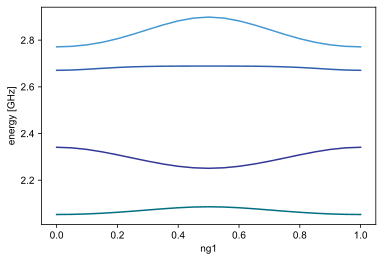

In [7]:
ng_list = np.linspace(0.0, 1.0, 21)
fig, ax = FQ.plot_evals_vs_paramvals("ng1", ng_list, evals_count=4, subtract_ground=False)

In [8]:
hilbertspcvchos = HilbertSpace([FQVG])
hilbertspcvchos.interaction_list = []
points = 21
param_name = 'ng'
param_vals = np.linspace(0.0, 1.0, points)

subsys_update_list = [FQVG]

def update_hilbertspace(param_val):
    nglist = np.zeros(2)
    nglist[0] = param_val
    FQVG.nglist = nglist
    
sweep = ParameterSweep(param_name=param_name, param_vals=param_vals,
                       evals_count=4, hilbertspace=hilbertspcvchos,
                       subsys_update_list=subsys_update_list,
                       update_hilbertspace=update_hilbertspace)
splot.bare_spectrum(sweep, FQVG, which = (0,1,2,3), subtract_ground = False, fig_ax = [fig, ax])[0]

/Users/danielweiss/PycharmProjects/scqubits/scqubits/core/vchos.py:688: UserWarning: Increasing kmax to cope with inner product nonpositivity
  warnings.warn("Increasing kmax to cope with inner product nonpositivity")
/Users/danielweiss/PycharmProjects/scqubits/scqubits/core/vchos.py:696: UserWarning: Attempt Fix-Heiberger algorithm to eliminate small eigenvalues
  warnings.warn("Attempt Fix-Heiberger algorithm to eliminate small eigenvalues")


TypeError: list indices must be integers or slices, not tuple

In [3]:
def perform_ng_sweep():
    hilbertspcvchos = HilbertSpace([FQVG])
    hilbertspcvchos.interaction_list = []
    points = 21
    param_name = 'ng'
    param_vals = np.linspace(0.0, 1.0, points)

    subsys_update_list = [FQVG]

    def update_hilbertspace(param_val):
        nglist = np.zeros(2)
        nglist[0] = param_val
        FQVG.nglist = nglist
    
    sweep = ParameterSweep(param_name=param_name, param_vals=param_vals,
                       evals_count=4, hilbertspace=hilbertspcvchos,
                       subsys_update_list=subsys_update_list,
                       update_hilbertspace=update_hilbertspace)
    return sweep.dressed_specdata.energy_table

In [4]:
ng_list = np.linspace(0.0, 1.0, 21)
FQ.ncut = 15
specdata_ed = FQ.get_spectrum_vs_paramvals('ng1', ng_list, evals_count=4, subtract_ground=False)
rel_dev_v = []
hilbert_dim_v = []
for ncut in range(1, 8):
    FQVG.global_exc = ncut
    specdata_v_tmp = perform_ng_sweep()
    rel_dev_mat = np.abs(specdata_v_tmp-specdata_ed.energy_table)/specdata_ed.energy_table
    max_rel_dev = np.max(rel_dev_mat)
    rel_dev_v.append(max_rel_dev)
    hilbert_dim_v.append(FQVG.hilbertdim())
    specdata_prev = specdata_v_tmp
    print(ncut, FQVG.hilbertdim(), max_rel_dev)

1 6 0.06091496249740859


2 12 0.01328025220951559


3 20 0.006506908611426195


4 30 0.00047978294740492165


5 42 5.2969437381743244e-05


6 56 3.83865577853871e-06


7 [[1.54182291e-06 2.24085170e-07 3.26616698e-06 1.04781451e-05]
 [1.54569617e-06 2.64852027e-07 3.44902343e-06 1.03909707e-05]
 [1.55325826e-06 3.81406167e-07 3.97916984e-06 1.01371647e-05]
 [1.55351168e-06 5.59459210e-07 4.76837947e-06 9.75070152e-06]
 [1.53063292e-06 7.79217761e-07 5.63132394e-06 9.28719535e-06]
 [1.46553215e-06 1.01820191e-06 6.34915713e-06 8.81514977e-06]
 [1.34069337e-06 1.25861130e-06 6.76894258e-06 8.43819739e-06]
 [1.15666925e-06 1.48415298e-06 6.87368457e-06 8.23452463e-06]
 [9.50613832e-07 1.67252686e-06 6.78422507e-06 8.19444202e-06]
 [7.87140265e-07 1.79953506e-06 6.66142058e-06 8.24383360e-06]
 [7.24888293e-07 1.84477902e-06 6.60986170e-06 8.27870678e-06]
 [7.87140274e-07 1.79953552e-06 6.66142059e-06 8.24383350e-06]
 [9.50613853e-07 1.67252736e-06 6.78422511e-06 8.19444201e-06]
 [1.15666929e-06 1.48415345e-06 6.87368479e-06 8.23452460e-06]
 [1.34069331e-06 1.25861083e-06 6.76894231e-06 8.43819742e-06]
 [1.46553215e-06 1.01820198e-06 6.34915726e-06 8.8151

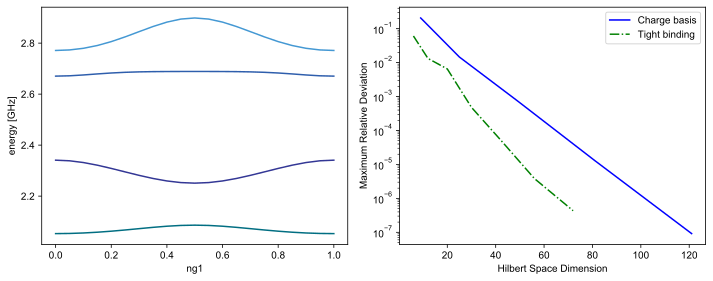

In [8]:
ng_list = np.linspace(0.0, 1.0, 21)
FQ.ncut = 15
specdata_ed = FQ.get_spectrum_vs_paramvals('ng1', ng_list, evals_count=4, subtract_ground=False)
rel_dev_ed = []
hilbert_dim_ed = []
for ncut in range(1, 6):
    FQ.ncut = ncut
    specdata_ed_tmp = FQ.get_spectrum_vs_paramvals('ng1', ng_list, evals_count=4, subtract_ground=False)
    rel_dev_mat = np.abs(specdata_ed_tmp.energy_table-specdata_ed.energy_table)/specdata_ed.energy_table
    max_rel_dev = np.max(rel_dev_mat)
    rel_dev_ed.append(max_rel_dev)
    hilbert_dim_ed.append(FQ.hilbertdim())
    print(ncut, FQ.hilbertdim(), max_rel_dev)

In [3]:
flux_list = np.linspace(0.0, 0.5, 8)
specdata = FQ.get_spectrum_vs_paramvals('flux', flux_list, evals_count = 8, get_eigenstates=True)
specdata.filewrite("testFQwrite_3.h5")
datafromfile = SpectrumData.create_from_file("testFQwrite_3.h5")

In [4]:
datafromfile.energy_table

array([[0.85154101, 1.66289544, 1.66341627, 2.38806765, 2.42585514,
        2.43431447, 3.06007539, 3.071187  ],
       [0.87738551, 1.68219394, 1.68440487, 2.39943316, 2.44019237,
        2.44896564, 3.06203864, 3.07616939],
       [0.95411725, 1.73892592, 1.74646891, 2.43076634, 2.48181328,
        2.49197776, 3.06440634, 3.08870502],
       [1.07930985, 1.82938617, 1.84683488, 2.47269785, 2.54606009,
        2.5595093 , 3.04796275, 3.10097093],
       [1.24881686, 1.94638615, 1.98056555, 2.50078019, 2.62259371,
        2.64155881, 2.92875294, 3.07944836],
       [1.45643367, 2.07556455, 2.13956168, 2.44366446, 2.68544776,
        2.70937141, 2.79990221, 3.06132166],
       [1.69227397, 2.1565099 , 2.28551555, 2.30784467, 2.67322214,
        2.69906951, 2.79759355, 3.03760753],
       [1.89814904, 2.00694504, 2.28771805, 2.41605558, 2.60874052,
        2.67531795, 2.80885703, 3.07557304]])

In [5]:
print(qubit.__version__)

1.2.1


In [6]:
FQVSG.eigenvals()

array([1.79942411, 2.09700158, 2.27983027, 2.3768991 , 2.64160876,
       2.68536754])

In [8]:
kin_bab = FQVB.kineticmat()
kin_squeeze = FQV.kineticmat()
pot_squeeze = FQV.potentialmat()
pot_bab = FQVB.potentialmat()
inn_bab = FQVB.inner_product()
inn_squeeze = FQV.inner_product()
#print(inn_bab, inn_squeeze)
print(inn_bab)
print(inn_squeeze)
print(np.allclose(inn_bab, inn_squeeze))
#print(kin_bab, kin_squeeze)
print(np.allclose(kin_bab, kin_squeeze))
#print(pot_bab, pot_squeeze)
print(np.allclose(pot_bab, pot_squeeze))

[[ 1.00000207e+00  1.27981384e-20  2.71531261e-20  7.17079538e-20
   4.58395719e-02  1.46074488e-09  1.00902578e-01  1.36799330e-08]
 [-1.27584338e-20  9.99982533e-01 -7.17079538e-20 -2.15151849e-19
  -1.46074488e-09  1.68095820e-02 -1.36799330e-08  1.57422395e-01]
 [-2.71531261e-20 -7.25549868e-20  9.99961358e-01 -2.20982955e-19
  -1.00902578e-01 -1.36799330e-08 -2.35346799e-01 -1.34117066e-08]
 [ 7.25549868e-20  2.15151849e-19  2.21022660e-19  1.00031187e+00
   1.36799330e-08 -1.57422395e-01  1.34117066e-08 -1.54335767e-01]
 [ 4.58395719e-02 -1.46074492e-09 -1.00902578e-01  1.36799329e-08
   1.00000207e+00 -2.38228016e-22  3.52159630e-20  4.60570686e-22]
 [ 1.46074493e-09  1.68095820e-02 -1.36799329e-08 -1.57422395e-01
   2.34257549e-21  9.99982533e-01 -3.84870248e-21 -3.03809791e-19]
 [ 1.00902578e-01 -1.36799329e-08 -2.35346799e-01  1.34117067e-08
  -3.69260528e-20  4.83077826e-22  9.99961358e-01  3.89370458e-20]
 [ 1.36799329e-08  1.57422395e-01 -1.34117067e-08 -1.54335767e-01
   

In [3]:
dim = (FQVS.num_exc+1)**2
kin_bab = FQVB.kineticmat()[dim:,dim:]
kin_squeeze = FQVS.kineticmat()[dim:, dim:]
pot_squeeze = FQVS.potentialmat()[dim:, dim:]
pot_bab = FQVB.potentialmat()[dim:,dim:]
inn_bab = FQVB.inner_product()[dim:,dim:]
inn_squeeze = FQVS.inner_product()[dim:,dim:]
#print(inn_bab, inn_squeeze)
print(np.allclose(inn_bab, inn_squeeze))
#print(kin_bab, kin_squeeze)
print(np.allclose(kin_bab, kin_squeeze))
#print(pot_bab, pot_squeeze)
print(np.allclose(pot_bab, pot_squeeze))

[[ 1.00003977e+00  5.73573654e-19 -3.18621791e-19  2.23475176e-10]
 [-5.87126181e-19  9.99694647e-01 -2.23475176e-10  2.28092918e-18]
 [ 3.32154514e-19 -2.23475176e-10  9.99467766e-01 -7.20637103e-18]
 [ 2.23475176e-10 -2.44289518e-18  7.58584179e-18  1.00406256e+00]] [[ 1.00003977e+00+0.j -1.50877744e-20+0.j  1.34608493e-20+0.j
   2.23475182e-10+0.j]
 [ 3.21078427e-20+0.j  9.99694647e-01+0.j -2.23475176e-10+0.j
  -3.23123690e-19+0.j]
 [ 1.36444627e-20+0.j -2.23475092e-10+0.j  9.99467766e-01+0.j
   5.54012487e-20+0.j]
 [ 2.23475182e-10+0.j  1.06654150e-19+0.j -2.72162274e-19+0.j
   1.00406256e+00+0.j]]
True
[[ 2.82869692e-01  8.87532345e-16 -4.43444734e-16 -3.42417412e-10]
 [ 8.76679100e-19  6.26765378e-01  3.42417412e-10 -4.46746237e-16]
 [-6.71479963e-19  3.42417412e-10  5.07044883e-01  8.92243331e-16]
 [-3.42417412e-10  2.97905875e-18 -7.53414631e-18  8.42409956e-01]] [[ 2.82869692e-01+0.j  2.94343949e-20+0.j -1.98335619e-20+0.j
  -3.42417412e-10+0.j]
 [-4.36221968e-20+0.j  6.267653

In [8]:
print(FQ.eigenvals())
print(FQV.eigenvals(), FQV.hilbertdim())
print(FQVS.eigenvals(), FQVS.hilbertdim())
print(FQVG.eigenvals(), FQVG.hilbertdim())
print(FQVSG.eigenvals(), FQVSG.hilbertdim())

[1.79932682 2.09687728 2.2772094  2.37348051 2.63859009 2.68436081]
[1.79932838 2.09688443 2.27729747 2.3739291  2.63910901 2.68445465] 50
[1.79932854 2.09688249 2.27732881 2.37378554 2.63891522 2.68457696] 50
[1.79944124 2.09699062 2.28000819 2.37882311 2.64298808 2.68557455] 30
[1.79942411 2.09700158 2.27983027 2.3768991  2.64160876 2.68536754] 30


In [9]:
print(FQ.eigenvals())
print(FQV.eigenvals(), FQV.hilbertdim())
print(FQVS.eigenvals(), FQVS.hilbertdim())
print(FQVG.eigenvals(), FQVG.hilbertdim())
print(FQVSG.eigenvals(), FQVSG.hilbertdim())

[1.79932682 2.09687728 2.2772094  2.37348051 2.63859009 2.68436081]
[1.79932838 2.09688443 2.27729747 2.3739291  2.63910901 2.68445465] 25
[1.79932854 2.09688248 2.2773288  2.37378554 2.6389152  2.68457695] 25
[1.79944124 2.09699062 2.28000819 2.37882311 2.64298808 2.68557455] 15
[1.79942411 2.09700156 2.27983026 2.3768991  2.64160875 2.68536753] 15


In [10]:
N = 4
ECB = 0.2
ECJ = 20.0/2.7
ECg = 20.0
flux = 0.0
EJ = 18.9586
EJlist = np.array([EJ for j in range(2*N)])
nglist = np.array([0.0 for j in range(2*N)])
CMV = qubit.CurrentMirrorVCHOS(N, ECB, ECJ, ECg, EJlist, nglist, flux, 
                               kmax=1, num_exc=2, squeezing=False)
CMVG = qubit.CurrentMirrorVCHOSGlobal(N, ECB, ECJ, ECg, EJlist, nglist, flux, 
                                      kmax=1, global_exc=2, squeezing=False)
CM = qubit.CurrentMirror(N, ECB, ECJ, ECg, EJlist, nglist, flux, ncut=3)

In [11]:
CMVG.eigenvals()

KeyboardInterrupt: 

In [5]:
evals_holder_vchos = []
hilbert_dim_vchos = []
evals_holder_vchos_global = []
hilbert_dim_vchos_global = []
for ncut in range(1, 4):
    print(ncut)
    CMV = qubit.CurrentMirrorVCHOS(N, ECB, ECJ, ECg, EJlist, nglist, flux, 
                                   kmax=1, num_exc=ncut, squeezing=False)
    evals = CMV.eigenvals()
    evals_holder_vchos.append(evals)
    hilbert_dim_vchos.append(CMV.hilbertdim())
    CMVG = qubit.CurrentMirrorVCHOSGlobal(N, ECB, ECJ, ECg, EJlist, nglist, flux, 
                                   kmax=1, global_exc=ncut, squeezing=False)
    evals = CMVG.eigenvals()
    evals_holder_vchos_global.append(evals)
    hilbert_dim_vchos_global.append(CMVG.hilbertdim())
    
    

1
2
3


In [6]:
evals_holder_ED = []
hilbert_dim_ED = []
for ncut in range(1, 7):
    print(ncut)
    CM = qubit.CurrentMirror(N, ECB, ECJ, ECg, EJlist, nglist, flux, ncut=ncut)
    evals = CM.eigenvals()
    evals_holder_ED.append(evals)
    hilbert_dim_ED.append((2*CM.ncut+1)**(CM.num_deg_freedom))

1
2
3
4
5
6


In [20]:
CM = qubit.CurrentMirror(N, ECB, ECJ, ECg, EJlist, nglist, flux, ncut=7)
evals = CM.eigenvals()
evals_holder_ED.append(evals)

In [21]:
print(np.array(evals_holder_ED)[-1,:])
print(np.array(evals_holder_vchos)[0,:])
print(np.array(evals_holder_vchos)[-1,:])

[37.5036985  41.00657259 41.03737585 44.3761203  44.47855065 44.52430147]
[37.66454782 41.2166912  41.21827147 44.63330746 44.75656744 48.13143512]
[37.51394954 41.0467031  41.04677482 44.44385195 44.54820087 44.56440727]


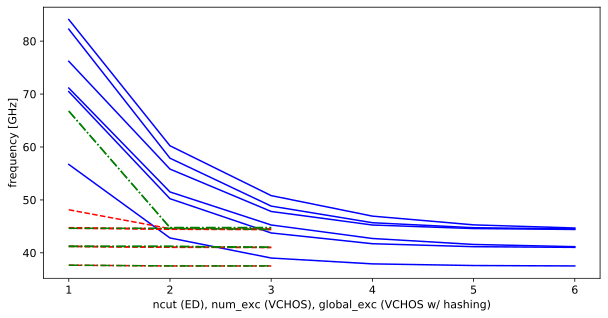

In [17]:
ncut_list = np.arange(1, 9)
fig,ax = plt.subplots(figsize=(10,5))
plt.plot(ncut_list[0:6], evals_holder_ED, color="blue")
plt.plot(ncut_list[0:3], evals_holder_vchos, color="red", linestyle='--')
plt.plot(ncut_list[0:3], evals_holder_vchos_global, color="green", linestyle='-.')
plt.xlabel("ncut (ED), num_exc (VCHOS), global_exc (VCHOS w/ hashing)")
plt.ylabel("frequency [GHz]")
plt.show()

In [8]:
print(hilbert_dim_ED)
print(hilbert_dim_vchos)
print(hilbert_dim_vchos_global)

[243, 3125, 16807, 59049, 161051, 371293]
[32, 243, 1024]
[6, 21, 56]


In [18]:
correct_array = np.array([37.5003354 , 41.00248316, 41.00255319, 44.36622042, 44.4624474 , 44.48319579])

In [22]:
evals_holder_vchos = np.array(evals_holder_vchos)
evals_holder_vchos_global = np.array(evals_holder_vchos_global)
vchos_percent_diff = 100*np.array([np.abs(evals_holder_vchos[i,:]-correct_array)/correct_array 
                               for i in range(3)])
vchos_global_percent_diff = 100*np.array([np.abs(evals_holder_vchos_global[i,:]-correct_array)/correct_array 
                               for i in range(3)])

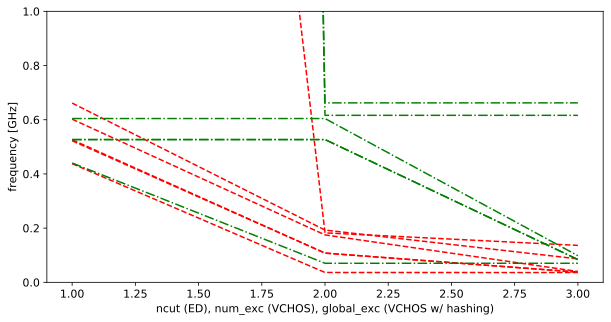

In [26]:
ncut_list = np.arange(1, 9)
fig,ax = plt.subplots(figsize=(10,5))
#plt.plot(ncut_list[0:6], evals_holder_ED, color="blue")
plt.plot(ncut_list[0:3], vchos_percent_diff, color="red", linestyle='--')
plt.plot(ncut_list[0:3], vchos_global_percent_diff, color="green", linestyle='-.')
plt.ylim(0,1)
plt.xlabel("ncut (ED), num_exc (VCHOS), global_exc (VCHOS w/ hashing)")
plt.ylabel("frequency [GHz]")
plt.show()

In [9]:
print(evals_holder_ED)
print(evals_holder_vchos)
print(evals_holder_vchos_global)

[array([56.70140312, 70.46042775, 71.13782448, 76.19151844, 82.26184779,
       84.08820282]), array([42.80612023, 50.22657124, 51.50082666, 55.82116382, 57.87979284,
       60.22545979]), array([39.01382439, 43.75076327, 45.25837763, 47.81235394, 48.82732037,
       50.8098161 ]), array([37.91111698, 41.7203811 , 42.70902272, 45.25314106, 45.68702751,
       46.93290294]), array([37.60014853, 41.15974483, 41.58172879, 44.58520793, 44.7446738 ,
       45.28091933]), array([37.52073588, 41.03067135, 41.1629697 , 44.41647763, 44.52028604,
       44.689744  ])]
[array([37.66454782, 41.2166912 , 41.21827147, 44.63330746, 44.75656744,
       48.13143512]), array([37.51394954, 41.0467031 , 41.04677482, 44.44385195, 44.54820087,
       44.56440727]), array([37.51388751, 41.0179229 , 41.0179777 , 44.38399225, 44.50092556,
       44.54382605])]
[array([37.66546139, 41.218532  , 41.218532  , 44.6343957 , 66.78197096,
       66.78197096]), array([37.52668893, 41.218532  , 41.218532  , 44.6343957 

In [4]:
inn_mat_s = FQVS.inner_product()
inn_mat = FQV.inner_product()
eigval_s, _ = sp.linalg.eig(inn_mat_s)
eigval, _ = sp.linalg.eig(inn_mat)
print(eigval_s, eigval)

[0.6611684 +0.j 1.33863567+0.j 1.00294684+0.j 0.99702312+0.j
 1.32255698+0.j 0.67869759+0.j 1.11800646+0.j 0.88249921+0.j] [0.66140363+0.j 0.99702037+0.j 1.0029497 +0.j 1.33840104+0.j
 0.67895007+0.j 0.88258552+0.j 1.11791858+0.j 1.32230067+0.j]


In [8]:
Xi = FQVS.Xi_matrix()

In [7]:
%lprun -f FQV.potentialmat FQV.potentialmat()

In [8]:
%lprun -f FQVS.potentialmat FQVS.potentialmat()

In [6]:
%lprun -f FQVSG.potentialmat FQVSG.potentialmat()

In [12]:
Cmat = FQVS.build_capacitance_matrix()
gmat_0 = FQVS.build_gamma_matrix(0)
#gmat_1 = FQVS.build_gamma_matrix(1)
omegasq_0, _ = sp.linalg.eigh(gmat_0, b=Cmat)
#omegasq_1, _ = sp.linalg.eigh(gmat_1, b=Cmat)
omega_0 = np.sqrt(omegasq_0)
#omega_1 = np.sqrt(omegasq_1)
#print(omega_0, omega_1)
print(omega_0)

[877.34948045 879.75086637]


In [19]:
M = FQVG.inner_product()
A = FQVG.hamiltonian()

def sorter(alpha, beta):
    out = np.empty_like(alpha, dtype=bool)
    x = alpha/beta
    out = np.logical_and(np.real(x) > 0, np.abs(np.imag(x)) < 10**(-9))
    return out

AA, BB, alpha, beta, Q, Z = sp.linalg.ordqz(A, M, sort=sorter)
#print(alpha, beta, alpha/beta)
#eigval, _ = sp.linalg.eigh(A, b=M, eigvals=(0, 5))
#eigvals = np.array([AA[i, i]/BB[i, i] for i in range(AA.shape[0])])
print(alpha/beta)
#print(eigval_4)
#eigval_prime = np.array([(eigval_4[i]*gamma+sigma)/(gamma-sigma*eigval_4[i])
#                        for i in range(len(eigval_4))])
#print(eigval_prime)

[ 2.08630981+2.40627965e-14j  2.25105581-1.81939437e-15j
  2.68895969+1.31937430e-13j  2.89871994-1.26061560e-11j
  3.12523284-6.61727118e-15j  3.3680692 -1.88313295e-11j
  3.57483809-1.06156718e-11j  3.73564271-1.05678764e-11j
  3.94580631+4.64234302e-14j  4.17529419-6.45945281e-11j
  4.38553445-1.88962858e-11j  4.41532679-9.85411188e-11j
  4.88262833+3.36435868e-13j  5.05840012-2.89846454e-13j
  5.07469445+2.82244271e-11j  5.1076864 -6.48358985e-11j
  5.1942959 -4.12011906e-10j  5.22776227-4.94860734e-10j
  5.78977357+1.76231829e-11j  5.92772147-4.41571164e-10j
  6.59596366+7.37493195e-11j  7.20794455-9.23964668e-12j
  7.20856268-6.79011192e-10j  9.3463564 +8.71809293e-10j
  7.70669311+9.12914832e-12j 18.67439683-2.10014976e-05j
 17.98917265+1.80076361e-05j  0.69058194-4.54914455e-04j
 16.60975646-8.01775682e-05j 16.52965684-1.29560932e-04j
 16.11319255-4.83212307e-06j 15.99762199+1.52104807e-06j
 15.70672928-2.19339222e-05j 15.66175189+1.52216459e-07j
 15.54681749-3.49559912e-05j 15

In [16]:
EJ = 10.
EC = 1.
ng = 0.0
transmon = qubit.Transmon(EJ=EJ, EC=EC, ng=ng, ncut=10)
transmonvchos = qubit.TransmonVCHOS(EJ=EJ, EC=EC, ng=ng, kmax=1, num_exc = 5)
transmonvchosunordered = qubit.TransmonVCHOSUnordered(EJ=EJ, EC=EC, ng=ng, kmax=1, num_exc = 11)

In [24]:
transmonvchos.num_exc = 14
eigval, eigvec = sp.linalg.eigh(transmonvchos.inner_product())
print(eigval)
print(eigvec[:,0])

[-2.57151370e-06  9.03049056e-08  8.12799185e-04  7.93897732e-03
  7.22282407e-01  8.95299466e-01  9.99669227e-01  9.99956605e-01
  1.00419649e+00  1.01774307e+00  1.68627292e+00  1.90245664e+00
  1.99999698e+00  1.99999749e+00  2.00000107e+00]
[ 1.14347275e-01-0.j  6.61470878e-12+0.j  4.36850499e-01+0.j
  2.00148648e-11+0.j  4.45763200e-01+0.j  2.94764362e-11+0.j
 -7.28189314e-02+0.j  2.57030371e-11+0.j -5.35222741e-01+0.j
  1.38705924e-11+0.j -5.03853428e-01+0.j  4.40380806e-12+0.j
 -2.23424764e-01+0.j  6.49056076e-13+0.j -4.27624926e-02+0.j]


a [[0. 1.]
 [0. 0.]]
un [[1.54308063 1.17520119]
 [1.17520119 1.54308063]]
norm [[1.64872127 1.64872127]
 [1.64872127 3.29744254]]
ref [[1.64872127 1.64872127]
 [1.64872127 3.29744254]]
a [[0.         1.         0.        ]
 [0.         0.         1.41421356]
 [0.         0.         0.        ]]
un [[1.63819248 1.58058656 0.90254046]
 [1.58058656 2.91457744 2.23528695]
 [0.90254046 2.23528695 2.27638496]]
norm [[1.64872127 1.64872127 1.16582199]
 [1.64872127 3.29744254 3.49746597]
 [1.16582199 3.49746597 5.77052445]]
ref [[1.64872127 1.64872127 1.16582199]
 [1.64872127 3.29744254 3.49746597]
 [1.16582199 3.49746597 5.77052445]]


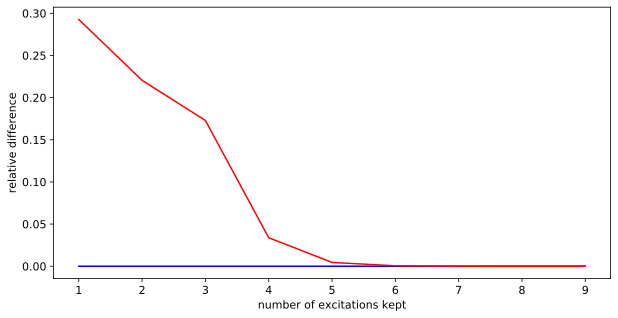

In [29]:
Xi = (8.0*transmon.EC/transmon.EJ)**(1/4)
transmonvchos = qubit.TransmonVCHOS(EJ=EJ, EC=EC, ng=ng, kmax=1, num_exc = 300)
a = transmonvchos.a_operator()
exp_ref = np.exp(0.5)*np.matmul(sp.linalg.expm(a.T), sp.linalg.expm(a))
norm_diff = []
nonorm_diff = []
for num in range(1, 10):
    transmonvchos = qubit.TransmonVCHOS(EJ=EJ, EC=EC, ng=ng, kmax=1, num_exc = num)
    a = transmonvchos.a_operator()
#    unord_tran_op = sp.linalg.expm(a + a.T)
    boundary_num = min(num+1, 4)
    unord_tran_op = sp.linalg.expm(a + a.T)[0:boundary_num, 0:boundary_num]
#    ord_tran_op = np.exp(0.5)*np.matmul(sp.linalg.expm(a.T), sp.linalg.expm(a))
    ord_tran_op = np.exp(0.5)*np.matmul(sp.linalg.expm(a.T), sp.linalg.expm(a))[0:boundary_num, 0:boundary_num]
#    exp_r = exp_ref[0:num+1, 0:num+1]
    exp_r = exp_ref[0:boundary_num, 0:boundary_num]
    if num == 1:
        print("a", a)
        print("un", unord_tran_op)
        print("norm", ord_tran_op)
        print("ref", exp_r)
    if num == 2:
        print("a", a)
        print("un", unord_tran_op)
        print("norm", ord_tran_op)
        print("ref", exp_r)
    norm_diff.append(np.sum(np.abs(exp_r-ord_tran_op)/exp_r/(boundary_num)**2))
    nonorm_diff.append(np.sum(np.abs(exp_r-unord_tran_op)/exp_r/(boundary_num)**2))
    
klist =np.arange(1, 10)
fig,ax = plt.subplots(figsize=(10,5))
plt.plot(klist, np.array(norm_diff), color="blue")
plt.plot(klist, np.array(nonorm_diff), color="red")
#plt.xlim(0, 40)
#plt.yscale("log")
plt.xlabel("number of excitations kept")
plt.ylabel("relative difference")
plt.show()
    

    #print(unordered_translation_op[0:4, 0:4])
#print(ordered_translation_op[0:4, 0:4])
                          

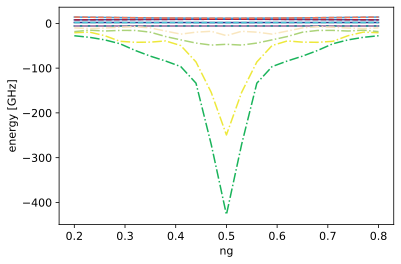

In [16]:
ng_list = np.linspace(0.2, 0.8, 21)

fig, axes = transmonvchos.plot_evals_vs_paramvals('ng', ng_list, evals_count=4, subtract_ground=False)
transmon.plot_evals_vs_paramvals('ng', ng_list, evals_count=4, subtract_ground=False, fig_ax=[fig, axes])
transmonvchosunordered.plot_evals_vs_paramvals('ng', ng_list, evals_count=4, subtract_ground=False, fig_ax=[fig, axes])
axes.properties()['children'][4].set_linestyle('--')
axes.properties()['children'][5].set_linestyle('--')
axes.properties()['children'][6].set_linestyle('--')
axes.properties()['children'][7].set_linestyle('--')
axes.properties()['children'][8].set_linestyle('-.')
axes.properties()['children'][9].set_linestyle('-.')
axes.properties()['children'][10].set_linestyle('-.')
axes.properties()['children'][11].set_linestyle('-.')


In [57]:
EJ = 10.
EC = 1.
ng = 0.0
nummax = 40
transmonvchos = qubit.TransmonVCHOS(EJ=EJ, EC=EC, ng=ng, kmax=1, num_exc = 4000)
transmonvchosunordered = qubit.TransmonVCHOSUnordered(EJ=EJ, EC=EC, ng=ng, kmax=1, num_exc = 4000)
t_ref = np.real(transmonvchos.kineticmat() + transmonvchos.potentialmat())[0:nummax, 0:nummax]
t_ref_un = np.real(transmonvchosunordered.kineticmat() + transmonvchosunordered.potentialmat())[0:nummax, 0:nummax]
print(np.max(np.abs(t_ref-t_ref_un)))

15.874061445375418


In [51]:
EJ = 10.
EC = 1.
ng = 0.0
nummax = 30
transmonvchos = qubit.TransmonVCHOS(EJ=EJ, EC=EC, ng=ng, kmax=1, num_exc = 500)
transmonvchosunordered = qubit.TransmonVCHOSUnordered(EJ=EJ, EC=EC, ng=ng, kmax=1, num_exc = 500)
t_ref = np.real(transmonvchos.kineticmat() + transmonvchos.potentialmat())[0:nummax, 0:nummax]
t_ref_un = np.real(transmonvchosunordered.kineticmat() + transmonvchosunordered.potentialmat())[0:nummax, 0:nummax]
print(np.max(np.abs(t_ref-t_ref_un)))
norm_diff_list = []
nonorm_diff_list = []
for num in range(1, nummax):
    transmonvchos = qubit.TransmonVCHOS(EJ=EJ, EC=EC, ng=ng, kmax=1, num_exc = num)
    transmonvchosunordered = qubit.TransmonVCHOSUnordered(EJ=EJ, EC=EC, ng=ng, kmax=1, num_exc = num)
    t_norm = np.real(transmonvchos.kineticmat() + transmonvchos.potentialmat())
    t_nonorm = np.real(transmonvchosunordered.kineticmat() + transmonvchosunordered.potentialmat())
    if num == 1:
        print(t_ref[0:num+1, 0:num+1], t_norm)
    norm_diff_mat = np.abs(t_ref[0:num+1, 0:num+1]-t_norm)
    nonorm_diff_mat = np.abs(t_ref[0:num+1, 0:num+1]-t_nonorm)
    for i in range(num+1):
        for j in range(num+1):
            if not (np.allclose(np.abs(t_ref[i, j]), 0.0) and np.allclose(np.abs(t_norm[i, j]), 0.0)):
                norm_diff_mat[i, j] = norm_diff_mat[i, j]/np.maximum(np.abs(t_ref[i, j]),np.abs(t_norm[i, j])) 
            else: 
                norm_diff_mat[i, j] = 0.0
            if not (np.allclose(np.abs(t_ref[i, j]), 0.0) and np.allclose(np.abs(t_nonorm[i, j]), 0.0)):
                nonorm_diff_mat[i, j] = nonorm_diff_mat[i, j]/np.maximum(np.abs(t_ref[i, j]),np.abs(t_nonorm[i, j])) 
            else:
                nonorm_diff_mat[i, j] = 0.0
            
    norm_diff = np.sum(norm_diff_mat)/(num+1)**2
    nonorm_diff = np.sum(nonorm_diff_mat)/(num+1)**2
    norm_diff_list.append(norm_diff)
    nonorm_diff_list.append(nonorm_diff)

0.033646160137848824
[[-5.76148913  0.        ]
 [ 0.          2.30821397]] [[-5.76148913  0.        ]
 [ 0.          2.30821397]]


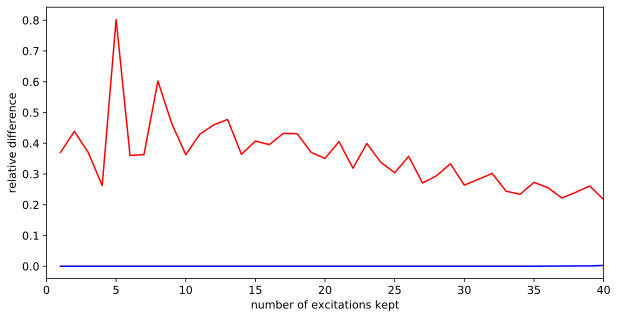

In [46]:
norm_diff_list_1 = norm_diff_list
nonorm_diff_list_1 = nonorm_diff_list

klist =np.arange(1, nummax)
fig,ax = plt.subplots(figsize=(10,5))
plt.plot(klist, np.array(norm_diff_list), color="blue")
plt.plot(klist, np.array(nonorm_diff_list), color="red")
plt.xlim(0, 40)
#plt.yscale("log")
plt.xlabel("number of excitations kept")
plt.ylabel("relative difference")
plt.show()

1
5
9
13
17
21
25
29
33
37
41
45
49


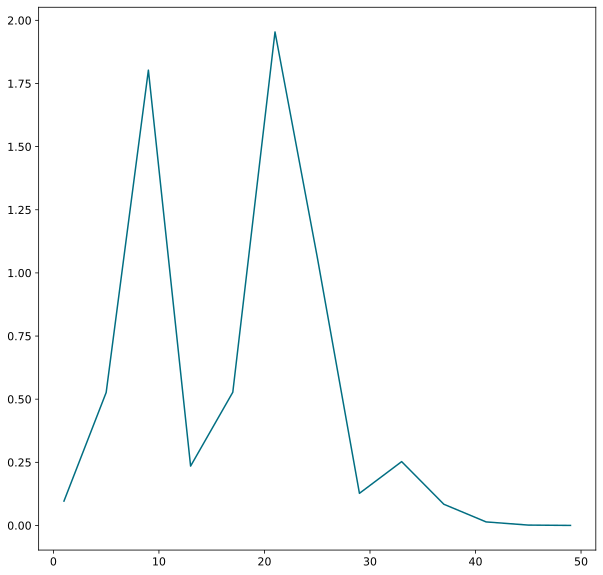

In [16]:
diff_holder = []
kmax = 50
for k in range(1, kmax, 4):
    print(k)
    FQV=qubit.FluxQubitVCHOS(ECJ=ECJ, ECg=ECg, EJ=EJ, alpha=ALPHA, ng1=0.0, ng2=0.0, 
                         flux=FLUX, kmax=1, num_exc=k, squeezing=True)
    kin_true = np.real(FQV.kineticmat())[0:4, 0:4]
    kin_approx = np.real(FQV._unordered_kineticmat())[0:4, 0:4]
    diff = np.abs(kin_true[0, 0]-kin_approx[0, 0])/kin_true[0, 0]
    diff_holder.append(diff)

[9.63747544e+00 5.26515844e+01 1.80277942e+02 2.34974008e+01
 5.27487081e+01 1.95404717e+02 1.06315803e+02 1.27162124e+01
 2.52728688e+01 8.38216969e+00 1.39801557e+00 1.40534489e-01
 9.25809776e-03]


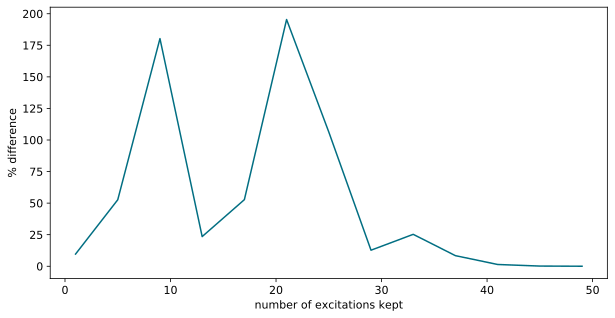

In [23]:
klist =np.arange(1, kmax, 4)
print(100*np.array(diff_holder))
fig,ax = plt.subplots(figsize=(10,5))
plt.plot(klist, 100*np.array(diff_holder))
plt.xlabel("number of excitations kept")
plt.ylabel("% difference")
plt.show()

[-0.17755966  0.17755966 -0.20849508  0.20849508]
[-0.17755966  0.17755966 -0.20849508  0.20849508]
[-0.17755966  0.17755966 -0.20849508  0.20849508]
[-0.12864381  0.12864381 -0.19811494  0.19811494]
[-0.12864381  0.12864381 -0.19811494  0.19811494]
[-0.17755966  0.17755966 -0.20849508  0.20849508]
[-0.12864381  0.12864381 -0.19811494  0.19811494]
[-0.12864381  0.12864381 -0.19811494  0.19811494]
[-0.17755966  0.17755966 -0.20849508  0.20849508]
[-0.17755966  0.17755966 -0.20849508  0.20849508]
[-0.17755966  0.17755966 -0.20849508  0.20849508]
[-0.12864381  0.12864381 -0.19811494  0.19811494]
[-0.12864381  0.12864381 -0.19811494  0.19811494]
[-0.17755966  0.17755966 -0.20849508  0.20849508]
[-0.12864381  0.12864381 -0.19811494  0.19811494]
[-0.12864381  0.12864381 -0.19811494  0.19811494]
[-0.17755966  0.17755966 -0.20849508  0.20849508]
[-0.17755966  0.17755966 -0.20849508  0.20849508]
[-0.17755966  0.17755966 -0.20849508  0.20849508]
[-0.12864381  0.12864381 -0.19811494  0.19811494]


[-0.14837828  0.14837828 -0.20017981  0.20017981]
[-0.14837828  0.14837828 -0.20017981  0.20017981]
[-0.16335048 -0.20367494  0.16335048  0.20367494]
[-0.16335048 -0.20367494  0.16335048  0.20367494]
[-0.16335048 -0.20367494  0.16335048  0.20367494]
[-0.1511194   0.1511194  -0.20069459  0.20069459]
[-0.1511194   0.1511194  -0.20069459  0.20069459]
[-0.16335048 -0.20367494  0.16335048  0.20367494]
[-0.1511194   0.1511194  -0.20069459  0.20069459]
[-0.1511194   0.1511194  -0.20069459  0.20069459]
[-0.16335048 -0.20367494  0.16335048  0.20367494]
[-0.16335048 -0.20367494  0.16335048  0.20367494]
[-0.16335048 -0.20367494  0.16335048  0.20367494]
[-0.1511194   0.1511194  -0.20069459  0.20069459]
[-0.1511194   0.1511194  -0.20069459  0.20069459]
[-0.16335048 -0.20367494  0.16335048  0.20367494]
[-0.1511194   0.1511194  -0.20069459  0.20069459]
[-0.1511194   0.1511194  -0.20069459  0.20069459]
[-0.16335048 -0.20367494  0.16335048  0.20367494]
[-0.16335048 -0.20367494  0.16335048  0.20367494]


[-0.14837828  0.14837828 -0.20017981  0.20017981]
[-0.16555765 -0.20433006  0.16555765  0.20433006]
[-0.14837828  0.14837828 -0.20017981  0.20017981]
[-0.14837828  0.14837828 -0.20017981  0.20017981]
[-0.16770054 -0.2049981   0.16770054  0.2049981 ]
[-0.16770054 -0.2049981   0.16770054  0.2049981 ]
[-0.16770054 -0.2049981   0.16770054  0.2049981 ]
[-0.14551322  0.14551322 -0.19970203  0.19970203]
[-0.14551322  0.14551322 -0.19970203  0.19970203]
[-0.16770054 -0.2049981   0.16770054  0.2049981 ]
[-0.14551322  0.14551322 -0.19970203  0.19970203]
[-0.14551322  0.14551322 -0.19970203  0.19970203]
[-0.16770054 -0.2049981   0.16770054  0.2049981 ]
[-0.16770054 -0.2049981   0.16770054  0.2049981 ]
[-0.16770054 -0.2049981   0.16770054  0.2049981 ]
[-0.14551322  0.14551322 -0.19970203  0.19970203]
[-0.14551322  0.14551322 -0.19970203  0.19970203]
[-0.16770054 -0.2049981   0.16770054  0.2049981 ]
[-0.14551322  0.14551322 -0.19970203  0.19970203]
[-0.14551322  0.14551322 -0.19970203  0.19970203]


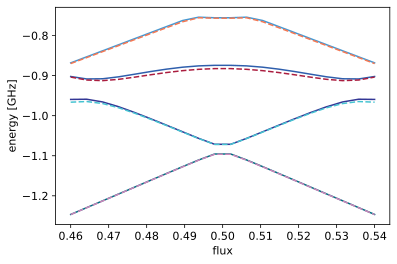

In [5]:
flux_list = np.linspace(.46, .54, 20)
fig, axes = FQV.plot_evals_vs_paramvals('flux', flux_list, evals_count=4, subtract_ground=False)
#FQV.plot_evals_vs_paramvals('flux', flux_list, evals_count=4, subtract_ground=False)
FQ.plot_evals_vs_paramvals('flux', flux_list, evals_count=4, subtract_ground=False, fig_ax=[fig, axes])
axes.properties()['children'][4].set_linestyle('--')
axes.properties()['children'][5].set_linestyle('--')
axes.properties()['children'][6].set_linestyle('--')
axes.properties()['children'][7].set_linestyle('--')

In [5]:
phi = np.array([-2.0*np.pi,2*np.pi])
#phi_delta_phi = np.matmul(phi,np.matmul(FQV.delta_inv_matrix(),phi))
#prefactor = np.exp(-.25 * phi_delta_phi)
#np.allclose(FQV.V_operator([-2.0*np.pi,-4*np.pi]).T, prefactor*sp.linalg.inv(FQV.V_operator([2.0*np.pi,4*np.pi])).T)
minima_list = FQV.sorted_minima()
delta_phi_kpm = phi+minima_list[0]-minima_list[1]
exp_min_diff = FQV._exp_a_operators_minima_diff(minima_list[0]-minima_list[1])
exp_a_list = FQV._exp_a_operators()
Xi = FQV.Xi_matrix()
Xi_inv = sp.linalg.inv(Xi)
delta_inv = np.matmul(np.transpose(Xi_inv), Xi_inv)
%lprun -f FQV.V_operator_full FQV.V_operator_full(minima_list[0]-minima_list[1], phi, exp_min_diff, exp_a_list, delta_inv)

#print(np.allclose(FQV.V_operator(delta_phi_kpm), FQV.V_operator_full(minima_list[0]-minima_list[1], 
#                                                     phi, exp_min_diff)))
#print(np.max(FQV.V_operator(delta_phi_kpm)-FQV.V_operator_full(minima_list[0]-minima_list[1], 
#                                                     phi, exp_min_diff)))
#print(FQV.V_operator(delta_phi_kpm)-FQV.V_operator_full(minima_list[0]-minima_list[1], 
#                                                     phi, exp_min_diff))
#print("d",FQV.V_operator(delta_phi_kpm))
#print("e", FQV.V_operator_full(minima_list[0]-minima_list[1], phi, exp_min_diff))

In [9]:
exp_min_diff = FQV._exp_a_operators_minima_diff(minima_list[0]-minima_list[1])
np.allclose(exp_min_diff, sp.linalg.inv(FQV._exp_a_operators_minima_diff(-(minima_list[0]-minima_list[1]))))

True

In [3]:
in_mat = FQV.inner_product()
in_old = FQV.inner_product_old()
#print(in_mat, in_bab)
print(np.allclose(in_mat, in_old), np.max(in_mat-in_old))

1.692626560907881e-14 3.4683650267921434e-15 jkvals =  (-1, -1)
6.716849298982197e-15 3.1086244689504383e-15 jkvals =  (-1, 0)
1.541336863906201e-25 1.846751033355279e-24 jkvals =  (-1, 1)
2.0539125955565396e-14 8.326672684688674e-17 jkvals =  (0, -1)
0.0 0.0 jkvals =  (0, 0)
8.326672684688674e-17 2.0539125955565396e-14 jkvals =  (0, 1)
1.846751033355279e-24 1.541336863906201e-25 jkvals =  (1, -1)
3.1086244689504383e-15 6.716849298982197e-15 jkvals =  (1, 0)
3.4683650267921434e-15 1.692626560907881e-14 jkvals =  (1, 1)
2.507391231801365e-23 5.37667398159468e-24 jkvals =  (-1, -1)
1.692711865184094e-35 4.137740114894452e-36 jkvals =  (-1, 0)
6.657006303513208e-61 3.96456831329844e-60 jkvals =  (-1, 1)
1.410835892556861e-10 6.840732424961971e-10 jkvals =  (0, -1)
1.2857075056064847e-20 6.166399856011306e-19 jkvals =  (0, 0)
5.64237288394698e-37 2.2945649728051052e-35 jkvals =  (0, 1)
8.327717813675686e-07 3.3809859654024887e-07 jkvals =  (1, -1)
5.0826898245759367e-11 8.653486816001532e-

In [4]:
np.unravel_index(np.argmax(kin_mat-kin_bab), kin_mat.shape)

(2, 6)

In [27]:
%lprun -f FQV.kineticmat FQV.kineticmat()
#evals_ed, evecs_ed = FQ.eigensys(evals_count=4)
#print(evals_vchos, evals_ed)

In [134]:
flux_list = np.linspace(0.0,0.5,100)
alpha_list = np.linspace(0.8,100,100)
harm_length_list = np.zeros((100,100))
FQV.flux = 0.45
for k, alpha in enumerate(alpha_list):
    for j, flux in enumerate(flux_list):
        FQV.alpha = alpha
        FQV.flux = flux
        harm_length = np.max(np.abs(sp.linalg.inv(FQV.Xi_matrix())))
        harm_length_list[k, j] = harm_length

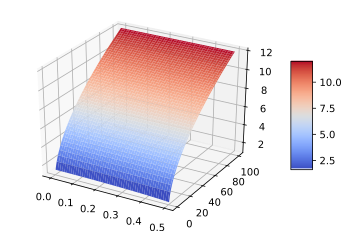

In [135]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X, Y = np.meshgrid(flux_list,alpha_list)

# Plot the surface.
surf = ax.plot_surface(X, Y, harm_length_list, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [ ]:
FQV.plot_wavefunction(which=0, mode='real',xlim=(-np.pi/2,3*np.pi/2), ylim=(-np.pi/2,3*np.pi/2))

In [ ]:
FQ.plot_wavefunction(which=0, mode='real',xlim=(-np.pi/2,3*np.pi/2), ylim=(-np.pi/2,3*np.pi/2))

(<Figure size 360x360 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f71b41ca890>)

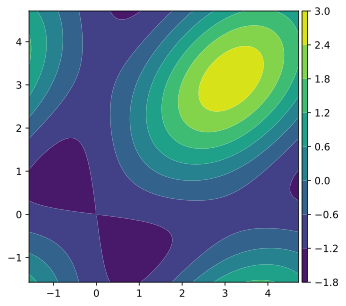

In [22]:
FQ.plot_potential()

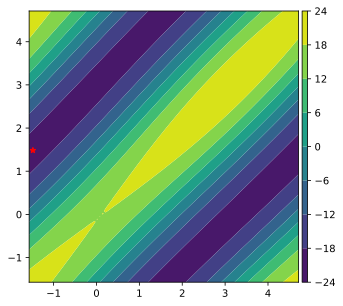

In [99]:
fig, axes = FQ.plot_potential()
axes.plot(FQV.sorted_minima()[0][0]-2*np.pi,FQV.sorted_minima()[0][1], marker="*", color="red")

(<Figure size 360x360 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2c999a9790>)

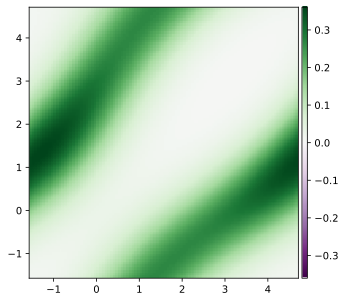

In [83]:
FQ.plot_wavefunction(which=0)

In [10]:
Cmat = FQV.build_capacitance_matrix()
gmat = FQV.build_gamma_matrix()  
omegasq, eigvec = sp.linalg.eigh(gmat, b=Cmat)
print(1./(np.sqrt(omegasq)*FQV.Z0))
print(np.sqrt(omegasq)/FQV.Z0)

[52.65152439 36.47956545]
[0.10088327 0.1456064 ]


In [9]:
Xi_inv = sp.linalg.inv(FQV.Xi_matrix())
print(np.matmul(Xi_inv,np.matmul(FQV.build_EC_matrix(), np.transpose(Xi_inv))))

[[ 1.64968813e-02 -1.04083409e-17]
 [-7.80625564e-18  1.93710587e-02]]


In [10]:
flux_list = np.linspace(.46, .54, 20)
fig, axes = FQVG.plot_evals_vs_paramvals('flux', flux_list, evals_count=4, subtract_ground=False)
#FQV.plot_evals_vs_paramvals('flux', flux_list, evals_count=4, subtract_ground=False, fig_ax=[fig, axes])
FQ.plot_evals_vs_paramvals('flux', flux_list, evals_count=4, subtract_ground=False, fig_ax=[fig, axes])
axes.properties()['children'][4].set_linestyle('--')
axes.properties()['children'][5].set_linestyle('--')
axes.properties()['children'][6].set_linestyle('--')
axes.properties()['children'][7].set_linestyle('--')
#axes.properties()['children'][8].set_linestyle('-.')
#axes.properties()['children'][9].set_linestyle('-.')
#axes.properties()['children'][8].set_linestyle('-.')
#axes.properties()['children'][9].set_linestyle('-.')

LinAlgError: the leading minor of order 25 of 'b' is not positive definite. The factorization of 'b' could not be completed and no eigenvalues or eigenvectors were computed.

In [28]:
FQ.hilbertdim()

121

In [16]:
FQVG.hilbertdim()

42

In [83]:
flux_list = np.linspace(.46, .54, 41)
FQ.ncut = 15
specdata_ed = FQ.get_spectrum_vs_paramvals('flux', flux_list, evals_count=4, subtract_ground=False)
rel_dev_ed = []
hilbert_dim_ed = []
for ncut in range(1, 8):
    FQ.ncut = ncut
    specdata_ed_tmp = FQ.get_spectrum_vs_paramvals('flux', flux_list, evals_count=4, subtract_ground=False)
    rel_dev_mat = np.abs(specdata_ed_tmp.energy_table-specdata_ed.energy_table)/specdata_ed.energy_table
    max_rel_dev = np.max(rel_dev_mat)
    rel_dev_ed.append(max_rel_dev)
    hilbert_dim_ed.append(FQ.hilbertdim())
    print(ncut, FQ.hilbertdim(), max_rel_dev)
    

1 9 0.3445418752343799


2 25 0.09698913303059888


3 49 0.023892946611436035


4 81 0.0043769007370835075


5 121 0.00047859765204821093


6 169 3.254629717341455e-05


7 225 1.5062750550723613e-06


In [84]:
flux_list = np.linspace(.46, .54, 41)
FQ.ncut = 15
specdata_ed = FQ.get_spectrum_vs_paramvals('flux', flux_list, evals_count=4, subtract_ground=False)
rel_dev_v = []
hilbert_dim_v = []
for ncut in range(1, 11):
    FQVG.global_exc = ncut
    specdata_v_tmp = FQVG.get_spectrum_vs_paramvals('flux', flux_list, evals_count=4, subtract_ground=False)
    rel_dev_mat = np.abs(specdata_v_tmp.energy_table-specdata_ed.energy_table)/specdata_ed.energy_table
    max_rel_dev = np.max(rel_dev_mat)
    rel_dev_v.append(max_rel_dev)
    hilbert_dim_v.append(FQVG.hilbertdim())
    print(ncut, FQVG.hilbertdim(), max_rel_dev)

1 6 0.030181115672780028


2 12 0.018036364008834332


3 20 0.011373347060342898


4 30 0.0027968996205899473


5 42 0.0004136198661663336


6 56 0.00018413667633708811


7 72 6.43486992535188e-05


8 90 1.9599822705916986e-05


9 110 5.839567023007003e-06


10 132 1.0063068483025575e-06


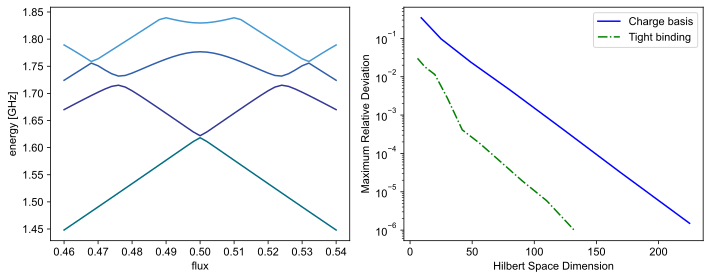

In [87]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
fig, ax1 = FQ.plot_evals_vs_paramvals('flux', flux_list, evals_count=4, subtract_ground=False, fig_ax = [fig, ax1])
ax2.plot(hilbert_dim_ed, rel_dev_ed, color="blue", label="Charge basis")
ax2.plot(hilbert_dim_v, rel_dev_v, color="green", linestyle='-.', label='Tight binding')
legend = ax2.legend()
plt.xlabel('Hilbert Space Dimension')
plt.ylabel('Maximum Relative Deviation')
plt.yscale('log')
plt.tight_layout()
plt.savefig('compare_tb_ed_flux.pdf')
plt.show()

In [23]:
flux_list = np.linspace(.46, .54, 20)
specdata_v = FQVG.get_spectrum_vs_paramvals('flux', flux_list, evals_count=4, subtract_ground=False)
specdata_ed = FQ.get_spectrum_vs_paramvals('flux', flux_list, evals_count=4, subtract_ground=False)

AttributeError: 'FluxQubitVCHOSGlobal' object has no attribute 'global_exc'

In [29]:
specdata_ed_5 = FQ.get_spectrum_vs_paramvals('flux', flux_list, evals_count=4, subtract_ground=False)

In [13]:
specdata_v.param_vals

array([0.46      , 0.46421053, 0.46842105, 0.47263158, 0.47684211,
       0.48105263, 0.48526316, 0.48947368, 0.49368421, 0.49789474,
       0.50210526, 0.50631579, 0.51052632, 0.51473684, 0.51894737,
       0.52315789, 0.52736842, 0.53157895, 0.53578947, 0.54      ])

In [41]:
print((specdata_v.energy_table-specdata_ed.energy_table)/specdata_ed.energy_table)
print(np.max((specdata_v.energy_table-specdata_ed.energy_table)/specdata_ed.energy_table))

[[1.24687508e-05 1.87480527e-04 1.95893012e-04 3.45887705e-04]
 [1.34346386e-05 2.09797106e-04 2.10508618e-04 1.94572871e-04]
 [1.44836157e-05 2.37129516e-04 1.12216779e-04 2.26561922e-04]
 [1.56282150e-05 2.72888836e-04 5.70176925e-05 2.44215634e-04]
 [1.68839350e-05 2.17551075e-04 1.13054088e-04 2.63678707e-04]
 [1.82720330e-05 9.46398352e-05 2.50324399e-04 2.85189606e-04]
 [1.98217847e-05 6.08153972e-05 3.09003768e-04 3.09104484e-04]
 [2.15950198e-05 4.44475395e-05 3.58298584e-04 3.78632649e-04]
 [2.37607384e-05 3.41277099e-05 4.00939954e-04 1.79618291e-04]
 [2.76080366e-05 2.54986779e-05 4.11508805e-04 6.45912387e-05]
 [2.76080379e-05 2.54986792e-05 4.11508882e-04 6.45912368e-05]
 [2.37607396e-05 3.41277127e-05 4.00940035e-04 1.79618312e-04]
 [2.15950207e-05 4.44475436e-05 3.58298644e-04 3.78632704e-04]
 [1.98217850e-05 6.08154005e-05 3.09003791e-04 3.09104481e-04]
 [1.82720327e-05 9.46398285e-05 2.50324387e-04 2.85189604e-04]
 [1.68839355e-05 2.17551102e-04 1.13054094e-04 2.636787

In [40]:
specdata_v.energy_table

array([[1.44811465, 1.67034107, 1.72446623, 1.78990668],
       [1.46600318, 1.68422291, 1.741134  , 1.77396481],
       [1.48395896, 1.69772217, 1.75728938, 1.75787479],
       [1.50197673, 1.7101549 , 1.7409482 , 1.77468596],
       [1.52005049, 1.71465325, 1.73192355, 1.79156479],
       [1.5381733 , 1.70087235, 1.74052873, 1.80850842],
       [1.55633666, 1.68350863, 1.75189513, 1.825514  ],
       [1.57452918, 1.66559554, 1.76259575, 1.84082671],
       [1.59273076, 1.64750844, 1.77142958, 1.83452607],
       [1.61084576, 1.62943436, 1.77671773, 1.83041459],
       [1.61084576, 1.62943436, 1.77671773, 1.83041459],
       [1.59273076, 1.64750844, 1.77142958, 1.83452607],
       [1.57452918, 1.66559554, 1.76259575, 1.84082671],
       [1.55633666, 1.68350863, 1.75189513, 1.825514  ],
       [1.5381733 , 1.70087235, 1.74052873, 1.80850842],
       [1.52005049, 1.71465325, 1.73192355, 1.79156479],
       [1.50197673, 1.7101549 , 1.7409482 , 1.77468596],
       [1.48395896, 1.69772217,

In [30]:
specdata_ed_5.energy_table

array([[1.44823654, 1.67082725, 1.72485492, 1.78944714],
       [1.46611525, 1.68459442, 1.74146153, 1.77372114],
       [1.48406134, 1.69796484, 1.75718456, 1.7581391 ],
       [1.50206949, 1.71022121, 1.74098018, 1.77488461],
       [1.52013369, 1.71445821, 1.73214681, 1.7916949 ],
       [1.53824693, 1.70076745, 1.74056941, 1.80856659],
       [1.55640066, 1.68346058, 1.75176763, 1.82549604],
       [1.57458336, 1.66558045, 1.76230825, 1.84059553],
       [1.59277461, 1.64751669, 1.77099411, 1.83468609],
       [1.61087625, 1.62946358, 1.77620994, 1.83081681],
       [1.61087625, 1.62946358, 1.77620994, 1.83081681],
       [1.59277461, 1.64751669, 1.77099411, 1.83468609],
       [1.57458336, 1.66558045, 1.76230825, 1.84059553],
       [1.55640066, 1.68346058, 1.75176763, 1.82549604],
       [1.53824693, 1.70076745, 1.74056941, 1.80856659],
       [1.52013369, 1.71445821, 1.73214681, 1.7916949 ],
       [1.50206949, 1.71022121, 1.74098018, 1.77488461],
       [1.48406134, 1.69796484,

In [4]:
print(specdata.energy_table)
print(specdataed.energy_table)

[[-1.03017116 -0.99314093 -0.76890365 -0.62010574]
 [-1.03013992 -0.99319465 -0.76877945 -0.6200465 ]
 [-1.0300491  -0.99335039 -0.76841893 -0.61986733]
 [-1.0299073  -0.99359232 -0.76785764 -0.61956505]
 [-1.02972834 -0.99389555 -0.76715215 -0.61913855]
 [-1.02953039 -0.99422827 -0.76637567 -0.61859589]
 [-1.02933452 -0.99455479 -0.76561144 -0.61796564]
 [-1.02916263 -0.99483916 -0.7649442  -0.61731171]
 [-1.02903486 -0.99504926 -0.76445028 -0.61674445]
 [-1.02896672 -0.99516085 -0.76418765 -0.61640587]
 [-1.02896672 -0.99516085 -0.76418765 -0.61640587]
 [-1.02903486 -0.99504926 -0.76445028 -0.61674445]
 [-1.02916263 -0.99483916 -0.7649442  -0.61731171]
 [-1.02933452 -0.99455479 -0.76561144 -0.61796564]
 [-1.02953039 -0.99422827 -0.76637567 -0.61859589]
 [-1.02972834 -0.99389555 -0.76715215 -0.61913855]
 [-1.0299073  -0.99359232 -0.76785764 -0.61956505]
 [-1.0300491  -0.99335039 -0.76841893 -0.61986733]
 [-1.03013992 -0.99319465 -0.76877945 -0.6200465 ]
 [-1.03017116 -0.99314093 -0.76

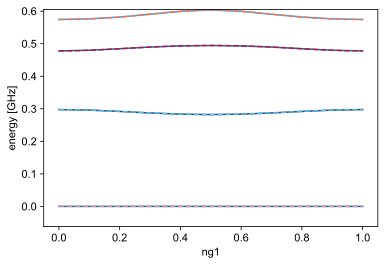

In [17]:
fig, axes = splot.dressed_spectrum(sweep)
FQ.plot_evals_vs_paramvals('ng1', ng_list, evals_count=4, subtract_ground=True, fig_ax = [fig, axes])
axes.properties()['children'][4].set_linestyle('--')
axes.properties()['children'][5].set_linestyle('--')
axes.properties()['children'][6].set_linestyle('--')
axes.properties()['children'][7].set_linestyle('--')

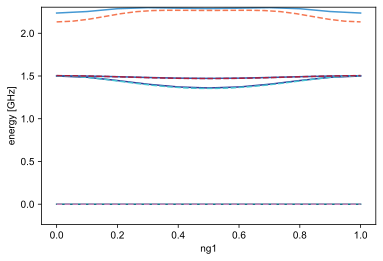

In [25]:
fig, axes = splot.dressed_spectrum(sweep)
FQ.plot_evals_vs_paramvals('ng1', ng_list, evals_count=4, subtract_ground=True, fig_ax = [fig, axes])
axes.properties()['children'][4].set_linestyle('--')
axes.properties()['children'][5].set_linestyle('--')
axes.properties()['children'][6].set_linestyle('--')
axes.properties()['children'][7].set_linestyle('--')

CPU times: user 4.96 s, sys: 252 ms, total: 5.22 s
Wall time: 932 ms


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7feec01249d0>)

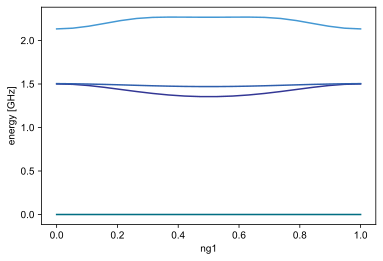

In [20]:
ng_list = np.linspace(0.0, 1.0, 20)
%time FQ.plot_evals_vs_paramvals('ng1', ng_list, evals_count=4, subtract_ground=True,)

/home/dkweiss/danny/Git_Code/scqubits/scqubits/scqubits/utils/plotting.py:310: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  axes.plot(xdata, ydata)


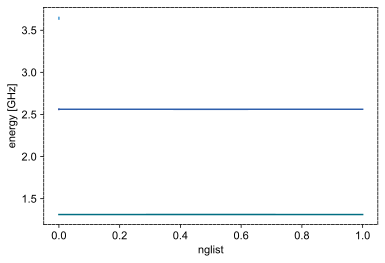

In [19]:
points = 21
ng_list_vals = np.linspace(0.0, 1.0, points)
ng_list = np.zeros((points, 2))
for k, elems in enumerate(ng_list_vals):
    tmplist = np.zeros(2)
    tmplist[0] = elems
    ng_list[k,:] = tmplist
fig, axes = FQV.plot_evals_vs_paramvals('nglist', ng_list, evals_count=4, subtract_ground=False)
#FQ.plot_evals_vs_paramvals('ng1', ng_list_vals, evals_count=4, subtract_ground=False, fig_ax=[fig, axes])
axes.properties()['children'][4].set_linestyle('--')
axes.properties()['children'][5].set_linestyle('--')
axes.properties()['children'][6].set_linestyle('--')
axes.properties()['children'][7].set_linestyle('--')